In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from PIL import Image

In [2]:

! pip install -q kaggle



!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json
chmod: cannot access '/root/.kaggle/kaggle.json': Permission denied


In [3]:
!kaggle datasets download -d 'alessiocorrado99/animals10'

animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from os import path
if(path.exists('animals')==False):
  ! unzip animals10.zip -d animals


In [5]:
! ls animals/raw-img/scoiattolo/ | wc -l

ls: cannot access 'animals/raw-img/scoiattolo/': No such file or directory
0


In [6]:
import os
#dir = os.listdir('/content/')

canedir = 'animals/raw-img/dog/'
cavallo = 'animals/raw-img/horse/'
elefante = 'animals/raw-img/elephant/'
farfalla = 'animals/raw-img/butterfly/'
gallina = 'animals/raw-img/chicken/'
gatto = 'animals/raw-img/cat/'
mucca = 'animals/raw-img/cow/'
pecora = 'animals/raw-img/sheepa/'
ragno = 'animals/raw-img/spider/'
scoiattolo = 'animals/raw-img/squirrel/'


import pathlib
path = pathlib.Path.cwd() / scoiattolo

image_count = len(list(path.glob('*')))
print(image_count)

print(path)

1862
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/animals/raw-img/squirrel


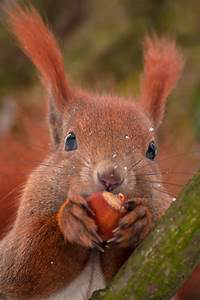

In [7]:
wiewiorka = list(path.glob('*'))
PIL.Image.open(str(wiewiorka[0]))

In [8]:
img_height = 190
img_width = 190
batch_size = 30

path = pathlib.Path.cwd() / 'animals/raw-img'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )


Found 26176 files belonging to 10 classes.
Using 20941 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

class_names = train_ds.class_names
print(class_names)

Found 26176 files belonging to 10 classes.
Using 5235 files for validation.
['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


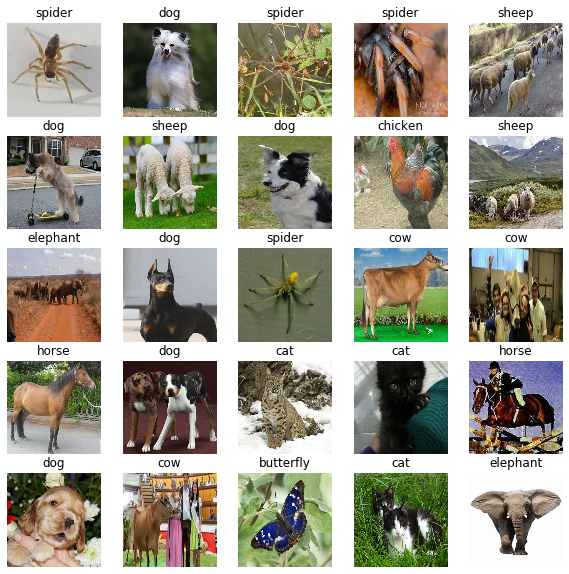

In [10]:
import matplotlib.pyplot as plt

tf.keras.layers.experimental.preprocessing.Resizing(
    img_height, img_width, interpolation='bilinear', name=None
)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(30, 190, 190, 3)
(30,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

    
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.94013244


In [13]:
num_classes = 10



model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(40, 3, input_shape=(img_height, img_width, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(80, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(160, 3, padding='same', activation='relu'),
    layers.Conv2D(160, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(320, activation='relu'),
    layers.Dense(num_classes)
])


In [14]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        3

In [15]:

epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
655/655 [==============================] - 249s 379ms/step - loss: 1.9280 - accuracy: 0.3282 - val_loss: 1.4279 - val_accuracy: 0.5219
Epoch 2/10
655/655 [==============================] - 230s 351ms/step - loss: 1.2420 - accuracy: 0.5773 - val_loss: 1.1893 - val_accuracy: 0.5990
Epoch 3/10
655/655 [==============================] - 228s 348ms/step - loss: 0.9253 - accuracy: 0.6868 - val_loss: 1.1835 - val_accuracy: 0.6248
Epoch 4/10
655/655 [==============================] - 249s 380ms/step - loss: 0.6695 - accuracy: 0.7769 - val_loss: 1.3249 - val_accuracy: 0.6180
Epoch 5/10
655/655 [==============================] - 240s 367ms/step - loss: 0.4224 - accuracy: 0.8604 - val_loss: 1.3271 - val_accuracy: 0.6180
Epoch 6/10
655/655 [==============================] - 235s 359ms/step - loss: 0.2327 - accuracy: 0.9215 - val_loss: 1.6615 - val_accuracy: 0.6392
Epoch 7/10
655/655 [==============================] - 239s 365ms/step - loss: 0.1312 - accuracy: 0.9585 - val_loss: 1.9260 -

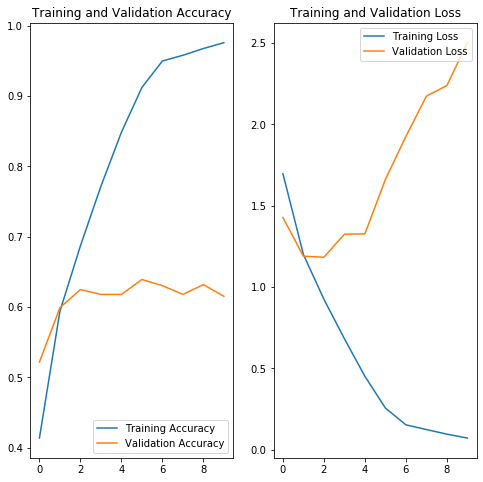

In [16]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

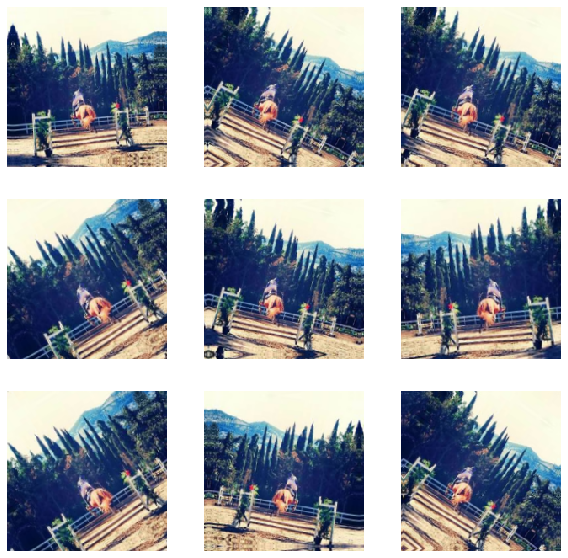

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
num_classes = 10
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(40, 3, input_shape=(img_height, img_width, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(80, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(160, 3, padding='same', activation='relu'),
    layers.Conv2D(160, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(160, activation='relu'),
    layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 190, 190, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 190, 190, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 190, 190, 40)      1120      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 95, 95, 80)        28880     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 160)      

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
699/699 [==============================] - 1290s 2s/step - loss: 2.1541 - accuracy: 0.2572 - val_loss: 1.6608 - val_accuracy: 0.4399
Epoch 2/20
699/699 [==============================] - 1317s 2s/step - loss: 1.5411 - accuracy: 0.4737 - val_loss: 1.3845 - val_accuracy: 0.5377
Epoch 3/20
699/699 [==============================] - 1273s 2s/step - loss: 1.2799 - accuracy: 0.5684 - val_loss: 1.1667 - val_accuracy: 0.5996
Epoch 4/20
699/699 [==============================] - 1215s 2s/step - loss: 1.1423 - accuracy: 0.6088 - val_loss: 1.1022 - val_accuracy: 0.6279
Epoch 5/20
699/699 [==============================] - 1169s 2s/step - loss: 1.0277 - accuracy: 0.6517 - val_loss: 1.0700 - val_accuracy: 0.6355
Epoch 6/20
699/699 [==============================] - 1171s 2s/step - loss: 0.9317 - accuracy: 0.6846 - val_loss: 0.9711 - val_accuracy: 0.6714
Epoch 7/20
699/699 [==============================] - 1171s 2s/step - loss: 0.8745 - accuracy: 0.7067 - val_loss: 0.9461 - val_accuracy:

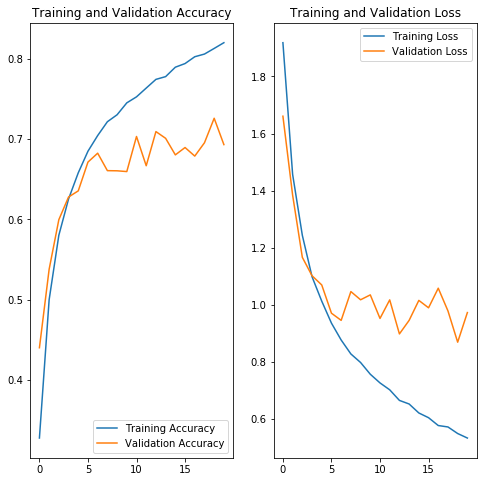

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/butterfly/butterfly1.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/butterfly/butterfly2.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/butterfly/butterfly3.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/butterfly/butterfly4.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/cat/cat1.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/cat/cat2.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/cat/cat3.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/cat/cat4.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/chicken/chicken1.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/chicken/chicken2.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/chicken/chicken3.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_animals/test_animals/chicken/chicken4.jpg
/mnt/c/Users/pc/OneDrive/Dokumenty/PSI_anima

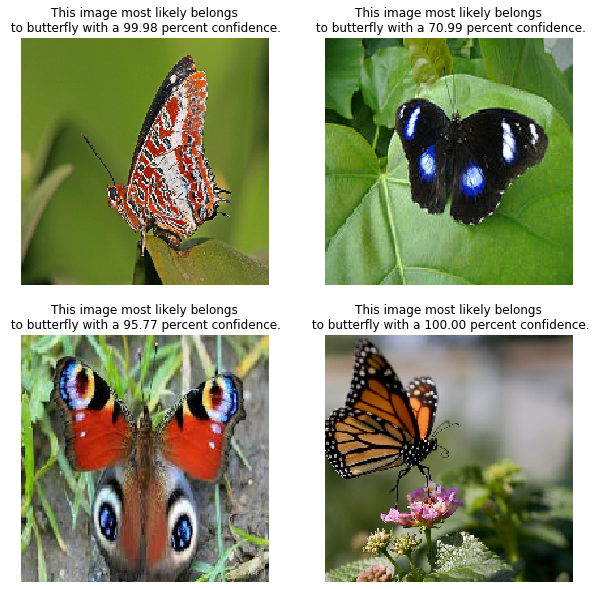

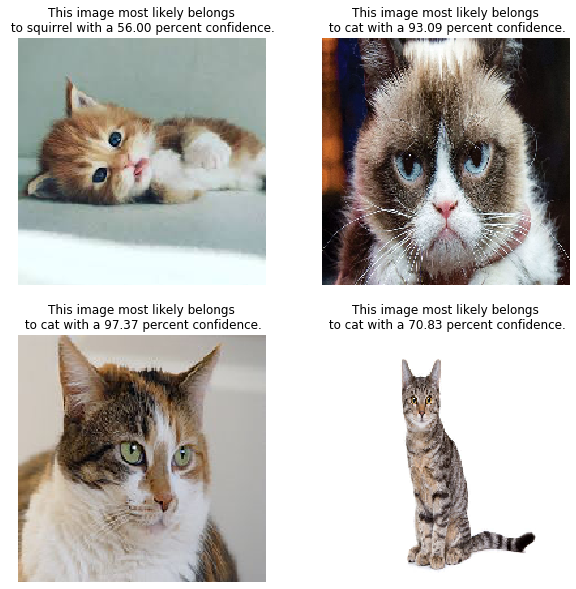

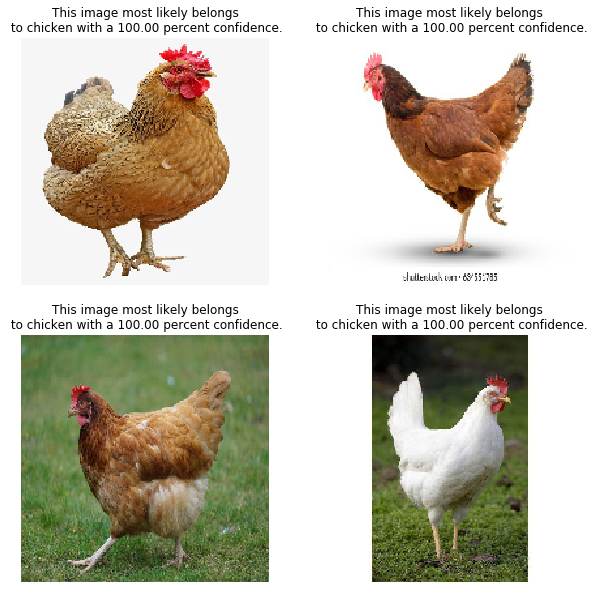

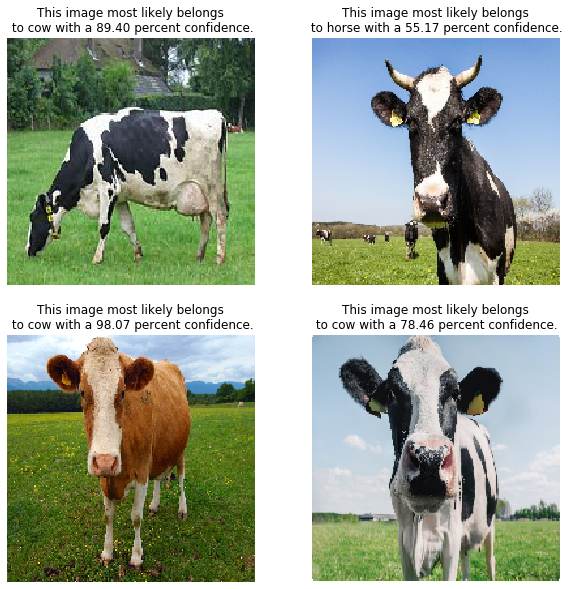

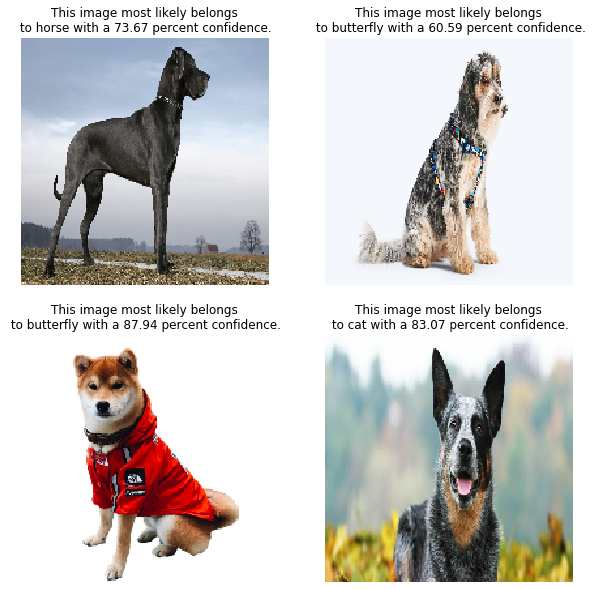

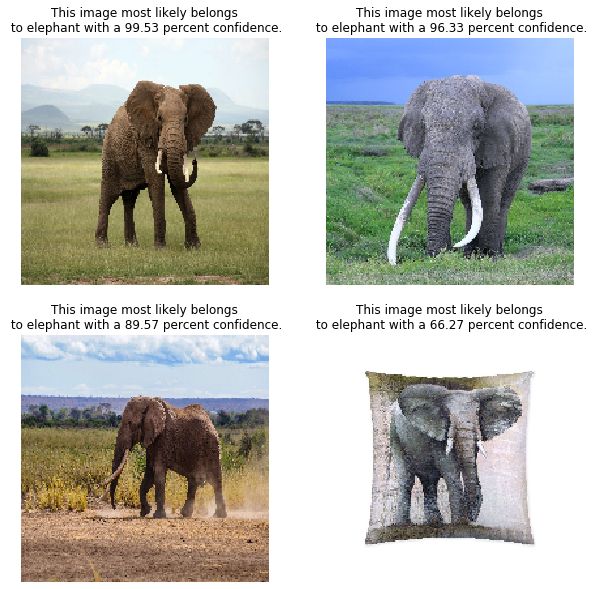

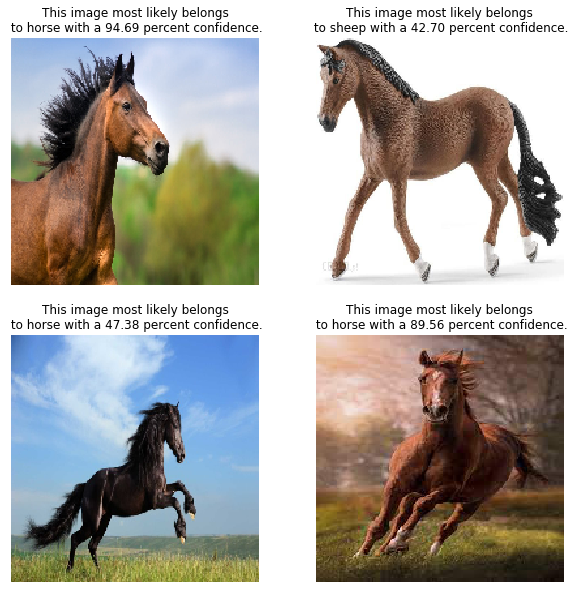

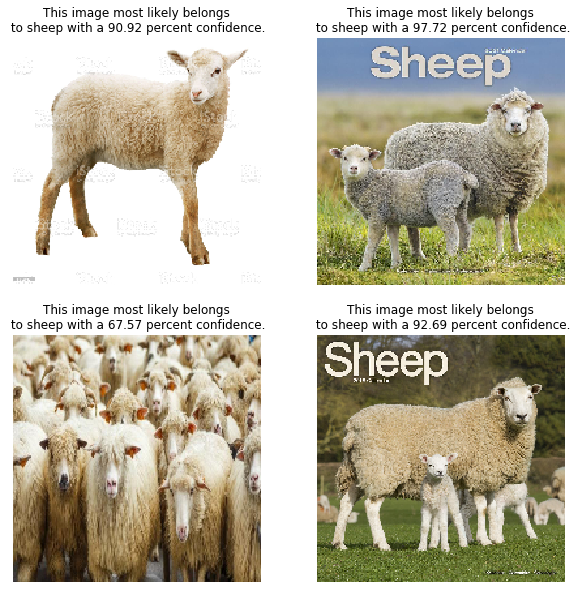

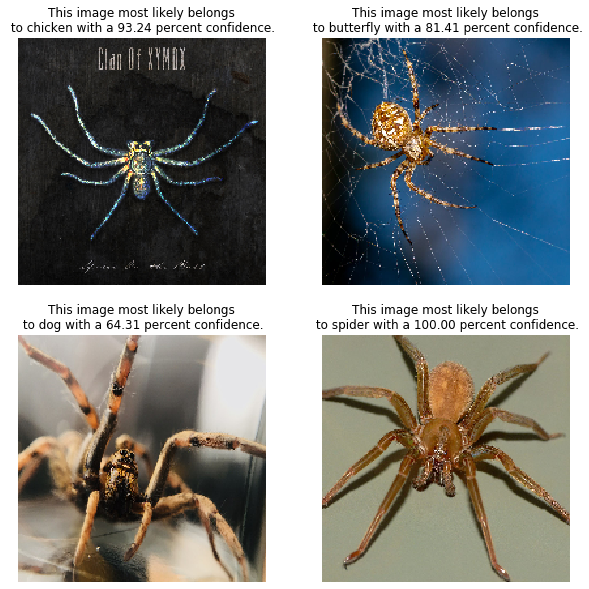

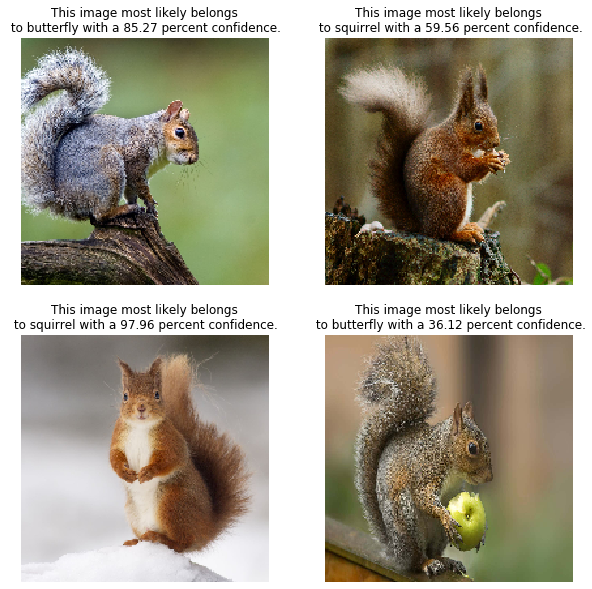

In [19]:
import pathlib
anim = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
for j in anim:
    test_path = pathlib.Path.cwd() / 'test_animals/{}'.format(j)

    #wiewiorka_url = "https://skarpetoholik.pl/4809-large_default/pin-motyl-monarcha-.jpg"
    #wiewiorka_path = tf.keras.utils.get_file('motyl3', origin=wiewiorka_url)

    #img = keras.preprocessing.image.load_img(
    #    wiewiorka_path, target_size=(img_height, img_width)
    #)
    #img_array = keras.preprocessing.image.img_to_array(img)
    #img_array = tf.expand_dims(img_array, 0) # Create a batch

    #predictions = model.predict(img_array)
    #score = tf.nn.softmax(predictions[0])

    #print(
     #   "This image most likely belongs to {} with a {:.2f} percent confidence."
     #   .format(class_names[np.argmax(score)], 100 * np.max(score))
    #)


    plt.figure(figsize=(10, 10))
    for i in range(4):
        temp = (test_path / '{}.jpg' .format(j + str(i+1)))
        print(temp)
        img = keras.preprocessing.image.load_img(
        temp, target_size=(img_height, img_width))

        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title("This image most likely belongs\n to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))
        plt.axis("off")